In [ ]:
#Splitting the data
import os
import shutil
import random

# The path to our dataset
dataset_path = '/content/drive/MyDrive/PlantRecognition'

# Defining the ratio for splitting the dataset
train_ratio = 0.75
valid_ratio = 0.10
test_ratio = 0.15

# The path to the output directory
output_path = '/content/drive/MyDrive/Dataset1/Plant disease recognition dataset'

# Creating the output directory if it doesn't exist
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Defining the names of the subdirectories for each set
train_dir = 'Train/Train'
valid_dir = 'Validation/Validation'
test_dir = 'Test/Test'

# Create the subdirectories for each set
os.makedirs(os.path.join(output_path, train_dir))
os.makedirs(os.path.join(output_path, valid_dir))
os.makedirs(os.path.join(output_path, test_dir))

# Loop over each class in the dataset
classes = os.listdir(dataset_path)
for cls in classes:
    # Create the subdirectories for each class in each set
    os.makedirs(os.path.join(output_path, train_dir, cls))
    os.makedirs(os.path.join(output_path, valid_dir, cls))
    os.makedirs(os.path.join(output_path, test_dir, cls))

    # Get the list of images for this class
    images = os.listdir(os.path.join(dataset_path, cls))
    num_images = len(images)

    # Shuffle the images
    random.shuffle(images)

    # Split the images into sets
    num_train = int(train_ratio * num_images)
    num_valid = int(valid_ratio * num_images)
    num_test = int(test_ratio * num_images)

    train_images = images[:num_train]
    valid_images = images[num_train:num_train+num_valid]
    test_images = images[num_train+num_valid:]

    # Copy the images to the corresponding subdirectories for each set
    for img in train_images:
        src_path = os.path.join(dataset_path, cls, img)
        dst_path = os.path.join(output_path, train_dir, cls, img)
        shutil.copyfile(src_path, dst_path)

    for img in valid_images:
        src_path = os.path.join(dataset_path, cls, img)
        dst_path = os.path.join(output_path, valid_dir, cls, img)
        shutil.copyfile(src_path, dst_path)

    for img in test_images:
        src_path = os.path.join(dataset_path, cls, img)
        dst_path = os.path.join(output_path, test_dir, cls, img)
        shutil.copyfile(src_path, dst_path)


In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import glob
import matplotlib.pyplot as plt
from tqdm import tqdm


# The transformation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the images to 224x224
    transforms.ToTensor(),         # Convert the images to PyTorch tensors
    transforms.Normalize(          # Normalize the images
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Loading the dataset
train_dataset = ImageFolder('/content/drive/MyDrive/Dataset1/Plant disease recognition dataset/Train/Train', transform=transform)
test_dataset = ImageFolder('/content/drive/MyDrive/Dataset1/Plant disease recognition dataset/Test/Test', transform=transform)
val_dataset = ImageFolder('/content/drive/MyDrive/Dataset1/Plant disease recognition dataset/Validation/Validation', transform=transform)

# Creating data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)


In [ ]:
# Defining the model architecture
model = models.mobilenet_v2(pretrained=False)
model.classifier = nn.Sequential(
    nn.Linear(1280, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 3)
)

# Defining the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Defining the number of epochs to train for
num_epochs = 10



/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
# Defining the path to save/load checkpoints
checkpoint_path = '/content/drive/MyDrive/checkpoint_PReco_MN_epoch10/checkpoint_{epoch}.pt'


# Check if a checkpoint exists and load it if so
try:
    latest_checkpoint = max(glob.glob('/content/drive/MyDrive/checkpoint_PReco_MN_epoch10/*.pt'), key=os.path.getctime)
    checkpoint_dict = torch.load(latest_checkpoint)
    model.load_state_dict(checkpoint_dict['model_state_dict'])
    optimizer.load_state_dict(checkpoint_dict['optimizer_state_dict'])
    start_epoch = checkpoint_dict['epoch']
    print(f"Loaded checkpoint from epoch {start_epoch}.")
except ValueError:
    print("No checkpoint found. Starting from epoch 1.")
    start_epoch = 0


# Create lists to store train and validation loss and accuracy
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

# Train the model
for epoch in range(start_epoch+1, num_epochs+1):
    # Set the model to training mode
    model.train()

    # Loop over the training dataset in batches
    train_loss = 0
    total_train_images = 0
    total_train_correct = 0
    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch}/{num_epochs}'):
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Calculate training loss and accuracy
        train_loss += loss.item() * labels.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train_correct += (predicted == labels).sum().item()
        total_train_images += labels.size(0)

    # Calculate training accuracy
    train_acc = total_train_correct / total_train_images

    # Evaluate the model on the validation set
    model.eval()
    with torch.no_grad():
        total_val_loss = 0
        total_val_correct = 0
        total_val_images = 0
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val_correct += (predicted == labels).sum().item()
            total_val_images += labels.size(0)
        val_loss = total_val_loss / total_val_images
        val_acc = total_val_correct / total_val_images
        print('Epoch [{}/{}], Training Loss: {:.4f}, Training Accuracy: {:.2f}%, Validation Loss: {:.4f}, Validation Accuracy: {:.2f}%'
              .format(epoch, num_epochs, train_loss/len(train_loader.dataset), train_acc*100, val_loss/len(val_loader.dataset), val_acc*100))

    # Append training and validation metrics to the corresponding lists
    train_loss_list.append(train_loss/len(train_loader.dataset))
    train_acc_list.append(train_acc*100)
    val_loss_list.append(val_loss/len(val_loader.dataset))
    val_acc_list.append(val_acc*100)

    # Save the checkpoint
    checkpoint_dict = {'epoch': epoch,
                       'model_state_dict': model.state_dict(),
                       'optimizer_state_dict': optimizer.state_dict()}
    torch.save(checkpoint_dict, checkpoint_path.format(epoch=epoch))
    print(f"Saved checkpoint for epoch {epoch}.")

No checkpoint found. Starting from epoch 1.


Epoch 1/10: 100%|██████████| 42/42 [08:18<00:00, 11.88s/it]


Epoch [1/10], Training Loss: 0.3687, Training Accuracy: 86.69%, Validation Loss: 0.0152, Validation Accuracy: 71.67%
Saved checkpoint for epoch 1.


Epoch 2/10: 100%|██████████| 42/42 [08:16<00:00, 11.82s/it]


Epoch [2/10], Training Loss: 0.2729, Training Accuracy: 90.70%, Validation Loss: 0.0097, Validation Accuracy: 78.33%
Saved checkpoint for epoch 2.


Epoch 3/10: 100%|██████████| 42/42 [08:19<00:00, 11.90s/it]


Epoch [3/10], Training Loss: 0.2216, Training Accuracy: 93.12%, Validation Loss: 0.0062, Validation Accuracy: 88.33%
Saved checkpoint for epoch 3.


Epoch 4/10: 100%|██████████| 42/42 [08:18<00:00, 11.86s/it]


Epoch [4/10], Training Loss: 0.1309, Training Accuracy: 96.14%, Validation Loss: 0.0035, Validation Accuracy: 93.33%
Saved checkpoint for epoch 4.


Epoch 5/10: 100%|██████████| 42/42 [08:13<00:00, 11.75s/it]


Epoch [5/10], Training Loss: 0.1285, Training Accuracy: 95.61%, Validation Loss: 0.0046, Validation Accuracy: 93.33%
Saved checkpoint for epoch 5.


Epoch 6/10: 100%|██████████| 42/42 [08:10<00:00, 11.68s/it]


Epoch [6/10], Training Loss: 0.1465, Training Accuracy: 94.93%, Validation Loss: 0.0030, Validation Accuracy: 93.33%
Saved checkpoint for epoch 6.


Epoch 7/10: 100%|██████████| 42/42 [08:09<00:00, 11.66s/it]


Epoch [7/10], Training Loss: 0.1650, Training Accuracy: 94.78%, Validation Loss: 0.0067, Validation Accuracy: 86.67%
Saved checkpoint for epoch 7.


Epoch 8/10: 100%|██████████| 42/42 [08:00<00:00, 11.44s/it]


Epoch [8/10], Training Loss: 0.0993, Training Accuracy: 97.05%, Validation Loss: 0.0065, Validation Accuracy: 88.33%
Saved checkpoint for epoch 8.


Epoch 9/10: 100%|██████████| 42/42 [08:10<00:00, 11.68s/it]


Epoch [9/10], Training Loss: 0.1585, Training Accuracy: 95.54%, Validation Loss: 0.0062, Validation Accuracy: 88.33%
Saved checkpoint for epoch 9.


Epoch 10/10: 100%|██████████| 42/42 [08:12<00:00, 11.74s/it]


Epoch [10/10], Training Loss: 0.0847, Training Accuracy: 96.97%, Validation Loss: 0.0035, Validation Accuracy: 95.00%
Saved checkpoint for epoch 10.


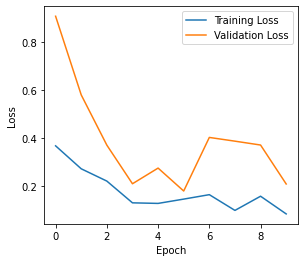

In [ ]:
# Plot the training and validation loss and accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

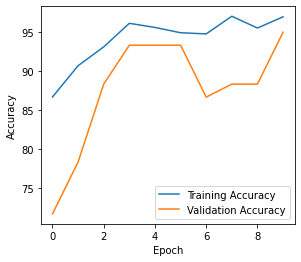

In [ ]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='Training Accuracy')
plt.plot(val_acc_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    total_test_loss = 0
    total_correct = 0
    total_images = 0
    # Use tqdm to add a progress bar
    for images, labels in tqdm(test_loader):
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_test_loss += loss.item() * labels.size(0)
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_images += labels.size(0)
    test_loss = total_test_loss / total_images
    accuracy = total_correct / total_images
    print('Test Loss: {:.4f}, Test Accuracy: {:.2f}%'.format(test_loss, accuracy*100))


100%|██████████| 5/5 [00:40<00:00,  8.14s/it]

Test Loss: 0.1547, Test Accuracy: 94.00%
